In [43]:
import os
import pandas as pd
import seaborn as sns
import pandas as pd

train_data_path ="./dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


DKTC 훈련 데이터를 이용해 협박, 갈취, 직장 내 괴롭힘, 기타 괴롭힘, 일반 대화 5가지 대화 유형 Class를 분류하는 딥러닝 모델을 만듭니다.

### EDA

In [44]:
# 필요없는 열 분리
train_data = train_data.iloc[:,1:]
train_data

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...
3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [45]:
train_data['class'].unique()

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화'], dtype=object)

In [46]:
# 분류별 count 파악
train_data['class'].value_counts()
# train_data.groupby('class').size().sort_values(ascending=False)

기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: class, dtype: int64

In [47]:
# 결측치 파악: 결측치 없음
train_data.isnull().sum()

class           0
conversation    0
dtype: int64

In [48]:
# 중복데이터 확인: 2개 대화 중복
train_data.shape[0], train_data['conversation'].nunique()

(3950, 3846)

In [49]:
# 중복제거
train_data = train_data.drop_duplicates(['conversation'])
train_data.shape[0]

3846

In [50]:
train_data.value_counts().head(4)

class        conversation                                                                                                                                                                                                                                                          
갈취 대화        100만 원만 내시죠.\n 내가 왜 100만 원을 내야돼?\n 아 그럼 공짜로 가겠단 말이야?\n 공짜는 왜 공짜야. 나도 할만큼했다고.\n 하 이 사람이 무서운 게 없군.\n 잘못한 게 없는데 뭐가 무서워.\n 하 아직 매운 맛을 못 봤군. 좋음 말로 할 때 100만 원 만 내.\n 100만원은 커녕 10만 원도 없어.\n 좋아 그럼 차키라도 넘기지.\n 운전으로 먹고 사는데 차를 넘기면 난 굶어주으란 말이야?.\n 그건 내가 알바 아니고 현금없으면 차라도 넘겨.    1
직장 내 괴롭힘 대화  씨는 좋겠다?\n네?\n애인도 있고 집도 있고 차도 있고. 히야 부러워\n아닙니다.\n그렇게 다 가졌으면 직장도 그냥 때려치지 응?\n아닙니다 괜찮습니다.\n아니 내가 안괜찮다고. 그렇게 살거면 걍 때려치워.\n죄송합니다\n죄송하면 애초에 죄송할 짓을 하지 말았어야지. 그러면서도 승진은 하고싶었나봐?\n아닙니다 죄송합니다.\n아니라고? 넌 배가 불렀나보다? 역시 다 가진놈들은 세상이 쉬운줄 아나봐 그치?\n. 죄송합니다.                             1
             어유 청년 공장일 힘들지 한잔해\n네 감사합니다.\n아니 우선 나 이런거 해보고 싶어 커플들이 마시듯이 술을 같이 마셔보고 싶어 청년 같이 해볼까?\n네? 저 여자친구 있는데.\n그래서 하기 싫다는거야?\n네 알겠습니다.\n아주 재밌게들 논다.             

In [51]:
x_train = train_data['conversation']
y_train = train_data['class']

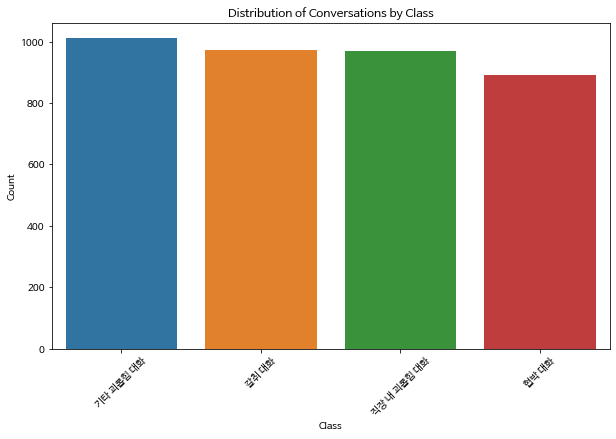

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 그래프 표시 order용
conversation_counts = train_data['class'].value_counts()
# train_data['class'].value_counts().plot(kind='bar')

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='class', order=conversation_counts.index)
plt.title('Distribution of Conversations by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### conversation 글자수(공백포함)

In [53]:
x_train = train_data['class']

print('conversation 최대 길이 :{}'.format(max(len(c) for c in train_data['conversation'])))
print('conversation 평균 길이 :{}'.format(sum(map(len, train_data['conversation']))/len(train_data['conversation'])))

conversation 최대 길이 :874
conversation 평균 길이 :227.7371294851794


#### class별 conversation 글자수(공백포함)

In [56]:
train_data['length'] = train_data.loc[:,'conversation'].apply(len)
train_data.sort_values('length',ascending=False)

/tmp/ipykernel_31/305660518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['length'] = train_data.loc[:,'conversation'].apply(len)


,class,conversation,length
1213,기타 괴롭힘 대화,네 아버님 안녕하십니까. 저는 따님의 남편이 될 길동 입니다.\n어. 어서 오시게....,874
92,직장 내 괴롭힘 대화,야 신규 너 똑바로 환자 관리 안 하냐? 인수인계 제대로 들은거 맞아? 너 누가 저...,843
3070,직장 내 괴롭힘 대화,혹시 오늘 56교시에 자율 빠지고 수업 보충인가요? 저희반 애들이 그러길래.\n네 ...,821
3120,기타 괴롭힘 대화,저기요 선생님 혹시 다음주인가 다다음주에 유치원 견학 가는 장소와 시간 알려주실 수...,819
617,협박 대화,야 헤어지자고 니가 먼저 문자하고 내 문자 안 읽어? 너 각오하는 게 좋을거야\n봐...,818
...,...,...,...
1038,갈취 대화,있는돈 다내놔\n없어\n말로할때 어서\n없다니깐\n나오면죽는다\n맞겨놨냐\n죽고싶어...,50
1989,갈취 대화,만원만빌려줘\n없어\n있자나\n없다니까\n있는거다알아\n정말이야\n뺏는다\n미안\n...,45
1953,기타 괴롭힘 대화,시간되면 술한잔해\n아뇨\n왜\n바빠요\n못생긴게\n네?\n어디서 비싼척\n그게아니...,45
807,직장 내 괴롭힘 대화,일다했나\n아니오\n빨리해\n네\n언제할꺼야\n내일까지\n오늘끝내\n안돼요\n밤새서...,41


In [58]:
# for i in train_data['class']
# max(len(s) for s in train_data['conversation'])))
# sum(map(len, train_data['conversation']))/len(train_data['conversation'])

conversation_counts = train_data['class'].value_counts()

for i in conversation_counts.index:
    subset = train_data[train_data['class']==i]
    print( f"{i}의 최대글자수: {max(subset['conversation'].apply(len))}" )
    print( f"{i}의 평균글자수 {sum(map(len,subset['conversation']))/len(subset['conversation']):.2f}" )
    print("-"*50)

기타 괴롭힘 대화의 최대글자수: 874
기타 괴롭힘 대화의 평균글자수 213.26
--------------------------------------------------
갈취 대화의 최대글자수: 678
갈취 대화의 평균글자수 216.22
--------------------------------------------------
직장 내 괴롭힘 대화의 최대글자수: 843
직장 내 괴롭힘 대화의 평균글자수 237.50
--------------------------------------------------
협박 대화의 최대글자수: 818
협박 대화의 평균글자수 246.09
--------------------------------------------------


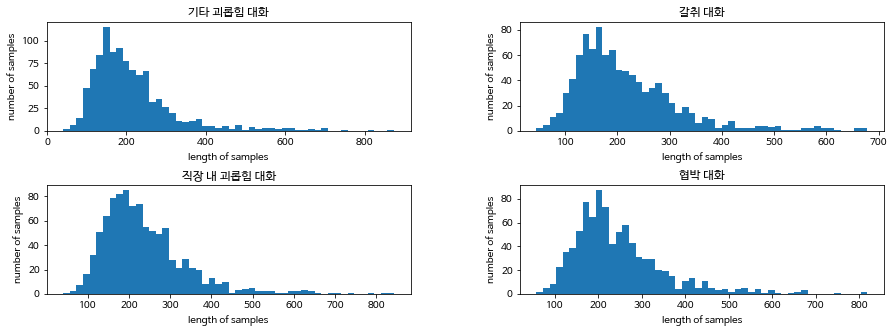

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='기타 괴롭힘 대화']], bins=50)
axes[0][0].set_xlabel('length of samples')
axes[0][0].set_ylabel('number of samples')
axes[0][0].set_title('기타 괴롭힘 대화')

axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='갈취 대화']], bins=50)
axes[0][1].set_xlabel('length of samples')
axes[0][1].set_ylabel('number of samples')
axes[0][1].set_title('갈취 대화')

axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='직장 내 괴롭힘 대화']], bins=50)
axes[1][0].set_xlabel('length of samples')
axes[1][0].set_ylabel('number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='협박 대화']
], bins=50)
axes[1][1].set_xlabel('length of samples')
axes[1][1].set_ylabel('number of samples')
axes[1][1].set_title('협박 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### 불용어(stopword)제외 후 class별 wordcloud 시각화

stop words list(https://www.ranks.nl/stopwords/korean/)

In [125]:
# 불용어 목록
stopwords = """
아
휴
아이구
아이쿠
아이고
어
나
우리
저희
따라
의해
을
를
에
의
가
으로
로
에게
뿐이다
의거하여
근거하여
입각하여
기준으로
예하면
예를 들면
예를 들자면
저
소인
소생
저희
지말고
하지마
하지마라
다른
물론
또한
그리고
비길수 없다
해서는 안된다
뿐만 아니라
만이 아니다
만은 아니다
막론하고
관계없이
그치지 않다
그러나
그런데
하지만
든간에
논하지 않다
따지지 않다
설사
비록
더라도
아니면
만 못하다
하는 편이 낫다
불문하고
향하여
향해서
향하다
쪽으로
틈타
이용하여
타다
오르다
제외하고
이 외에
이 밖에
하여야
비로소
한다면 몰라도
외에도
이곳
여기
부터
기점으로
따라서
할 생각이다
하려고하다
이리하여
그리하여
그렇게 함으로써
하지만
일때
할때
앞에서
중에서
보는데서
으로써
로써
까지
해야한다
일것이다
반드시
할줄알다
할수있다
할수있어
임에 틀림없다
한다면
등
등등
제
겨우
단지
다만
할뿐
딩동
댕그
대해서
대하여
대하면
훨씬
얼마나
얼마만큼
얼마큼
남짓
여
얼마간
약간
다소
좀
조금
다수
몇
얼마
지만
하물며
또한
그러나
그렇지만
하지만
이외에도
대해 말하자면
뿐이다
다음에
반대로
반대로 말하자면
이와 반대로
바꾸어서 말하면
바꾸어서 한다면
만약
그렇지않으면
까악
툭
딱
삐걱거리다
보드득
비걱거리다
꽈당
응당
해야한다
에 가서
각
각각
여러분
각종
각자
제각기
하도록하다
와
과
그러므로
그래서
고로
한 까닭에
하기 때문에
거니와
이지만
대하여
관하여
관한
과연
실로
아니나다를가
생각한대로
진짜로
한적이있다
하곤하였다
하
하하
허허
아하
거바
와
오
왜
어째서
무엇때문에
어찌
하겠는가
무슨
어디
어느곳
더군다나
하물며
더욱이는
어느때
언제
야
이봐
어이
여보시오
흐흐
흥
휴
헉헉
헐떡헐떡
영차
여차
어기여차
끙끙
아야
앗
아야
콸콸
졸졸
좍좍
뚝뚝
주룩주룩
솨
우르르
그래도
또
그리고
바꾸어말하면
바꾸어말하자면
혹은
혹시
답다
및
그에 따르는
때가 되어
즉
지든지
설령
가령
하더라도
할지라도
일지라도
지든지
몇
거의
하마터면
인젠
이젠
된바에야
된이상
만큼	어찌됏든
그위에
게다가
점에서 보아
비추어 보아
고려하면
하게될것이다
일것이다
비교적
좀
보다더
비하면
시키다
하게하다
할만하다
의해서
연이서
이어서
잇따라
뒤따라
뒤이어
결국
의지하여
기대여
통하여
자마자
더욱더
불구하고
얼마든지
마음대로
주저하지 않고
곧
즉시
바로
당장
하자마자
밖에 안된다
하면된다
그래
그렇지
요컨대
다시 말하자면
바꿔 말하면
즉
구체적으로
말하자면
시작하여
시초에
이상
허
헉
허걱
바와같이
해도좋다
해도된다
게다가
더구나
하물며
와르르
팍
퍽
펄렁
동안
이래
하고있었다
이었다
에서
로부터
까지
예하면
했어요
해요
함께
같이
더불어
마저
마저도
양자
모두
습니다
가까스로
하려고하다
즈음하여
다른
다른 방면으로
해봐요
습니까
했어요
말할것도 없고
무릎쓰고
개의치않고
하는것만 못하다
하는것이 낫다
매
매번
들
모
어느것
어느
로써
갖고말하자면
어디
어느쪽
어느것
어느해
어느 년도
라 해도
언젠가
어떤것
어느것
저기
저쪽
저것
그때
그럼
그러면
요만한걸
그래
그때
저것만큼
그저
이르기까지
할 줄 안다
할 힘이 있다
너
너희
당신
어찌
설마
차라리
할지언정
할지라도
할망정
할지언정
구토하다
게우다
토하다
메쓰겁다
옆사람
퉤
쳇
의거하여
근거하여
의해
따라
힘입어
그
다음
버금
두번째로
기타
첫번째로
나머지는
그중에서
견지에서
형식으로 쓰여
입장에서
위해서
단지
의해되다
하도록시키다
뿐만아니라
반대로
전후
전자
앞의것
잠시
잠깐
하면서
그렇지만
다음에
그러한즉
그런즉
남들
아무거나
어찌하든지
같다
비슷하다
예컨대
이럴정도로
어떻게
만약
만일
위에서 서술한바와같이
인 듯하다
하지 않는다면
만약에
무엇
무슨
어느
어떤
아래윗
조차
한데
그럼에도 불구하고
여전히
심지어
까지도
조차도
하지 않도록
않기 위하여
때
시각
무렵
시간
동안
어때
어떠한
하여금
네
예
우선
누구
누가 알겠는가
아무도
줄은모른다
줄은 몰랏다
하는 김에
겸사겸사
하는바
그런 까닭에
한 이유는
그러니
그러니까
때문에
그
너희
그들
너희들
타인
것
것들
너
위하여
공동으로
동시에
하기 위하여
어찌하여
무엇때문에
붕붕
윙윙
나
우리
엉엉
휘익
윙윙
오호
아하
어쨋든
만 못하다	하기보다는
차라리
하는 편이 낫다
흐흐
놀라다
상대적으로 말하자면
마치
아니라면
쉿
그렇지 않으면
그렇지 않다면
안 그러면
아니었다면
하든지
아니면
이라면
좋아
알았어
하는것도
그만이다
어쩔수 없다
하나
일
일반적으로
일단
한켠으로는
오자마자
이렇게되면
이와같다면
전부
한마디
한항목
근거로
하기에
아울러
하지 않도록
않기 위해서
이르기까지
이 되다
로 인하여
까닭으로
이유만으로
이로 인하여
그래서
이 때문에
그러므로
그런 까닭에
알 수 있다
결론을 낼 수 있다
으로 인하여
있다
어떤것
관계가 있다
관련이 있다
연관되다
어떤것들
에 대해
이리하여
그리하여
여부
하기보다는
하느니
하면 할수록
운운
이러이러하다
하구나
하도다
다시말하면
다음으로
에 있다
에 달려 있다
우리
우리들
오히려
하기는한데
어떻게
어떻해
어찌됏어
어때
어째서
본대로
자
이
이쪽
여기
이것
이번
이렇게말하자면
이런
이러한
이와 같은
요만큼
요만한 것
얼마 안 되는 것
이만큼
이 정도의
이렇게 많은 것
이와 같다
이때
이렇구나
것과 같이
끼익
삐걱
따위
와 같은 사람들
부류의 사람들
왜냐하면
중의하나
오직
오로지
에 한하다
하기만 하면
도착하다
까지 미치다
도달하다
정도에 이르다
할 지경이다
결과에 이르다
관해서는
여러분
하고 있다
한 후
혼자
자기
자기집
자신
우에 종합한것과같이
총적으로 보면
총적으로 말하면
총적으로
대로 하다
으로서
참
그만이다
할 따름이다
쿵
탕탕
쾅쾅
둥둥
봐
봐라
아이야
아니
와아
응
아이
참나
년
월
일
령
영
일
이
삼
사
오
육
륙
칠
팔
구
이천육
이천칠
이천팔
이천구
하나
둘
셋
넷
다섯
여섯
일곱
여덟
아홉
령
영
내가
진짜
"""

# 문자열을 리스트로 변환
stopwords_list = stopwords.strip().split('\n')

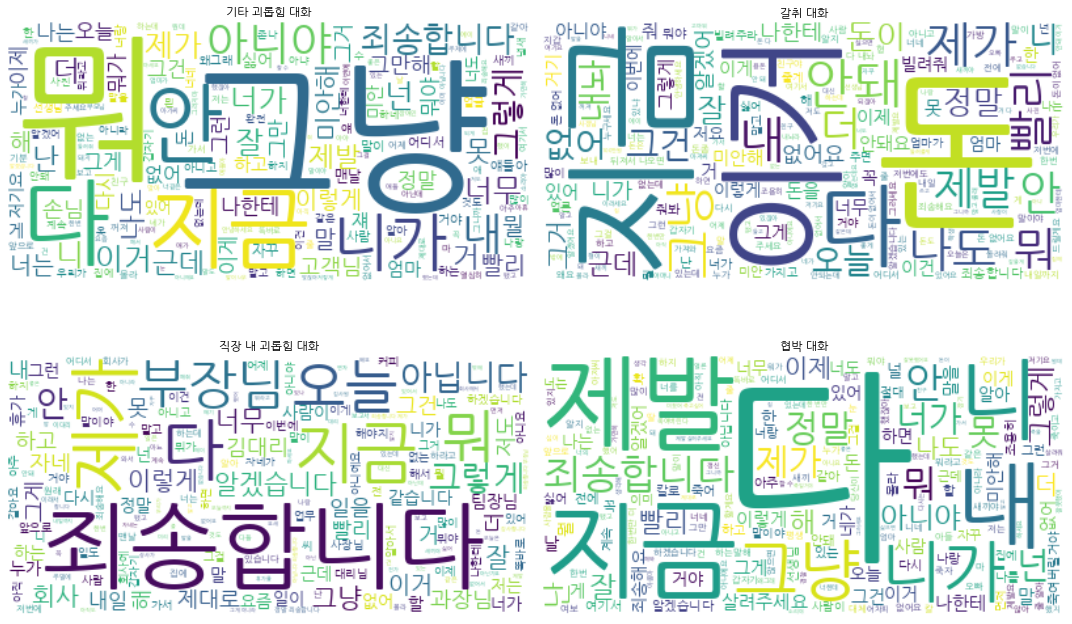

In [126]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 설정 (예: 나눔고딕)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 한글 폰트 경로 설정 (NanumGothic.ttf 파일 경로를 지정)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 시스템에 따라 경로가 다를 수 있음

# 불용어 리스트 (예: 한국어 불용어)
stopwords_set = set(stopwords_list)

# 대화 텍스트 데이터
conversation_classes = ['기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화', '협박 대화']
conversation_texts = [train_data['conversation'][train_data['class'] == cls] for cls in conversation_classes]

# 모든 대화 텍스트를 하나의 문자열로 결합
all_conversation_texts = [" ".join(texts) for texts in conversation_texts]

# 서브플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# 각 대화 텍스트에 대해 워드 클라우드 생성 및 시각화
for i, (ax, texts, cls) in enumerate(zip(axes, all_conversation_texts, conversation_classes)):
    wordcloud = WordCloud(font_path=font_path, background_color="white", stopwords=stopwords_set).generate(texts)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()
